In [1]:
# 导入包
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import os
import cv2
import pickle

In [2]:
# 读取数据 将图像读入图像列表中
img_list=[]
label_list=[]
path='./English/Hnd/Img/'
for n,i in enumerate(os.listdir(path)):
	file_path=path+i
	# print(file_path)
	# print(n)
	if file_path[-1]!='~' and n <11:
		for j in os.listdir(file_path):
			# print(file_path+'/'+j)
			img_list.append(file_path+'/'+j)
			label_list.append(n-1)


(900, 1200, 3)


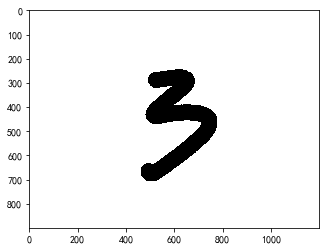

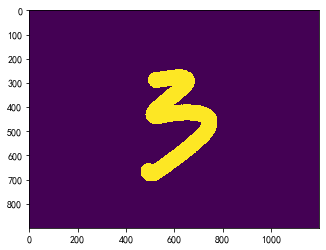

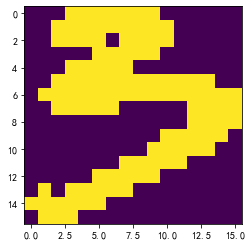

In [3]:
# 读取图像列表中的图像，生成数据
# 先看一下图像的size -1是按照原格式读取，避免图像和原始图像不一致等问题
img=cv2.imread(img_list[200],-1)
print(img.shape)
# 是三通道(900 1200)
plt.figure()
plt.imshow(img)
# 这样直接训练肯定效果并不是很好，想办法进行一下resize
# 先将其转化为二值图像，因为本来就都是黑白的，这样好训练一些
# 不需要二值化 直接取第一个维度试试
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
difference = (img_gray.max() - img_gray.min()) // 2
_, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)

# 最大图像灰度值减去原图像，即可得到反转的图像
img_binary=1-img_binary
plt.figure()
plt.imshow(img_binary)
resize_room1=16
resize_room2=16
# 注意下 测试集中的数字是28*28的 那么不妨将输入的图像变为28*28的看看结果
# 可以先试试28 如果特征损失比较厉害可以换大一点的


x=np.where(img_binary==1)[0]
y=np.where(img_binary==1)[1]
img_new=img_binary[min(x):max(x),min(y):max(y)]
img_new=cv2.resize(img_new,(resize_room1,resize_room2))
plt.figure()
plt.imshow(img_new)
# 可以看到，基本保留了图像的原始特征，这样说明这个reszie是合理的
# resize成32 然后取2*2作为最小统计块


In [4]:
# 对所有图像进行resize
img_list_new=[]
for n,img in enumerate(img_list):
	img_data=cv2.imread(img)
	# gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
	# 最大图像灰度值减去原图像，即可得到反转的图像
	img_gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
	difference = (img_gray.max() - img_gray.min()) // 2
	_, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
	img_binary=1-img_binary
	x=np.where(img_binary==1)[0]
	y=np.where(img_binary==1)[1]
	img_new=img_binary[min(x):max(x),min(y):max(y)]
	img_new=cv2.resize(img_new,(16,16))
	img_list_new.append(img_new)



# 这个数据处理时间比较长

550


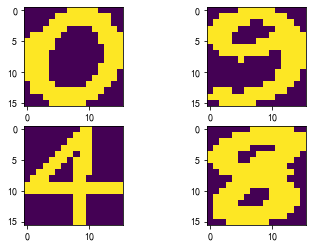

In [5]:
# 随便看一下数据
X=img_list_new
import random
img_select=random.sample(X,4)
print(len(X))
# print(img_select)
plt.figure()
for n,i in enumerate(img_select):
	plt.subplot(2,2,n+1)
	plt.imshow(i)

# 感觉结果还行

In [6]:
y=np.array(label_list)
X_new=[]
for i in X:
	X_new.append(i.flatten())
X=X_new
X=np.array(X)
print(X.shape)
print(y.shape)


(550, 256)
(550,)


In [7]:

# 数据归一化





In [14]:
# 定义神经网络64-100-10,64像素即64通道输入，隐藏层稍多于输入层，输出层为0-9，所以是10个
# 输入层到隐藏层v,隐藏层到输出层w
V = np.random.random((256,64)) * 2 - 1
W = np.random.random((64,10)) * 2 - 1
# 数据切分 train_test_split(X,y)可以把输入数据和标签数据切分为训练集和测试集
# default: 1/4测试集，3/4训练集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# 标签二值化
# 0->100000000
# 3->001000000
# 9->000000001
label_train = LabelBinarizer().fit_transform(y_train)
# label_train=label_train+0.01
# label_train[label_train==1.01]=0.99
# print(label_train)
# X_test=(X_test/255.0*0.99)+0.01
# X_train=(X_train/255.0 * 0.99) + 0.01

# 激活函数
def sigmoid(x):
    return 1/(1+np.exp(-x))
def dsigmoid(x):
    s = 1/(1+np.exp(-x))
    return s*(1-s)

# 训练模型
def train(X,y,Steps = 10000,lr = 0.17):
    global W,V
    acc_max=0
    for n in range(Steps):
        # 随机选取一个数据
        i = np.random.randint(X.shape[0])
        x = X[i]
        # 把数据变为2维数据，一维数据不能矩阵乘法
        
        x = np.atleast_2d(x)
        # BP算法公式
        L1 = sigmoid(np.dot(x,V))
        L2 = sigmoid(np.dot(L1,W))
        
        # 学习信号
        # print(y[i],L2)
        print((y[i]-L2))
        L2_delta = (y[i]-L2)*dsigmoid(np.dot(L1,W))
        L1_delta = np.dot(L2_delta,W.T)*dsigmoid(np.dot(x,V))
        
        # 更新权值
        W += lr*np.dot(L1.T,L2_delta)
        V += lr*np.dot(x.T,L1_delta)
        
        #每训练1000次预测一次准确率
        if n%1000 == 0:
            print(X_test.shape)
            output = predict(X_test)
            # print(output)
            # predictions：最大值所在位置（0-9）->预测的标签值
            predictions = np.argmax(output,axis = 1)
            acc = np.mean(np.equal(predictions,y_test))
            if(acc>acc_max):
                W_best=W
                V_best=V
                acc_max=acc

            print("steps:",n,"accuracy:",acc)
    return W_best,V_best,acc_max
def predict(x):
    L1 = sigmoid(np.dot(x,V))
    L2 = sigmoid(np.dot(L1,W))
    return L2



W_best,V_best,acc_max=train(X_train,label_train,4)

[[-0.00564547 -0.88237087 -0.97064233 -0.84126321 -0.01049742 -0.82059797
  -0.29218946  0.89794592 -0.1215533  -0.07553741]]
(110, 256)
steps: 0 accuracy: 0.07272727272727272
[[ 0.94597291 -0.40083754 -0.79179534 -0.99522482 -0.00629935 -0.70252583
  -0.15057039 -0.07561402 -0.42264269 -0.35793361]]
[[-0.27816993 -0.07403835 -0.481947   -0.70199564  0.99831071 -0.8172992
  -0.38662396 -0.44558048 -0.30384727 -0.16864415]]
[[-0.02032357 -0.91893178 -0.44076863 -0.9050824  -0.00777099  0.80453855
  -0.21647291 -0.04453903 -0.41246854 -0.02689652]]


In [418]:
print(acc_max)


0.9454545454545454


In [420]:
from sklearn import svm
from sklearn import datasets
import numpy as np

clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_train,y_train)
score_rbf = clf_rbf.score(X_test,y_test)
print("The score of rbf is : %f"%score_rbf)

The score of rbf is : 0.927273
